Axel LABROUSSE

Stevan LE STANC

TP1 détection d'anomalies

In [1]:
import numpy as np 
np.set_printoptions(threshold=10000, suppress = True) 
import pandas as pd 
import warnings 
import matplotlib.pyplot as plt 
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, average_precision_score, precision_recall_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor

# Base de données mouse.txt
## Importation des données

In [3]:
data = pd.read_table('mouse.txt', header = None, sep = ' ')
data

,0,1
0,0.456601,0.432806
1,0.611378,0.528625
2,0.450299,0.711606
3,0.639015,0.460744
4,0.628957,0.323470
...,...,...
495,0.151506,0.876586
496,0.860308,0.633833
497,0.862083,0.591805
498,0.916030,0.523391


On remarque qu'on a 500 points et deux variables. Les valeurs sont comprises entre 0 et 1 pour les deux colonnes.

## Visualisation des données

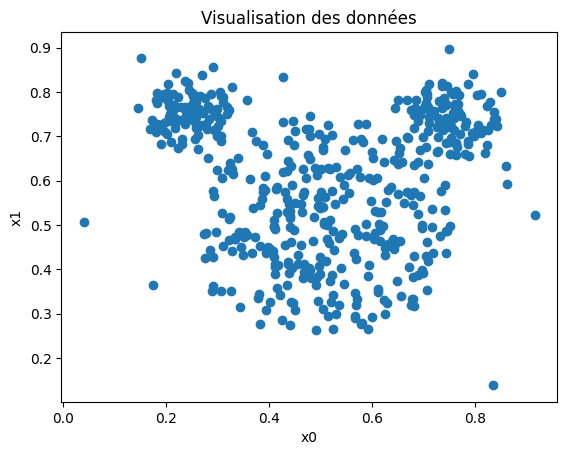

In [4]:
plt.scatter(data[0], data[1]) 
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Visualisation des données')
plt.show()

## Local Outlier Factor

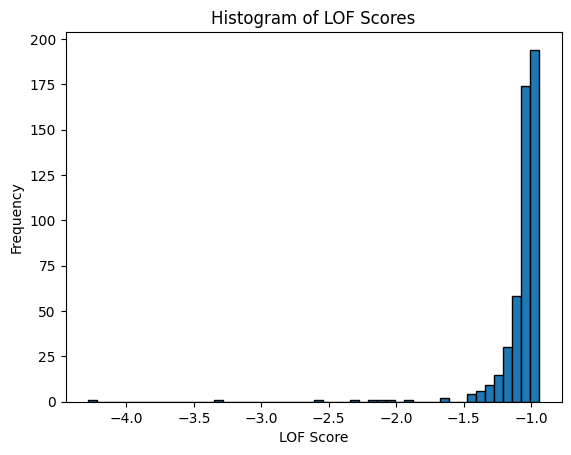

In [5]:
# Initialize the Local Outlier Factor model
lof = LocalOutlierFactor(n_neighbors=20)

lof.fit(data)

# Get the LOF scores
scores_lof = lof.negative_outlier_factor_

# Plot the histogram of LOF scores
plt.hist(scores_lof, bins=50, edgecolor='k')
plt.xlabel('LOF Score')
plt.ylabel('Frequency')
plt.title('Histogram of LOF Scores')
plt.show()

On choisi donc notre taux de contamination est de -1,5 

On applique donc ce seuil à notre algorithme final.

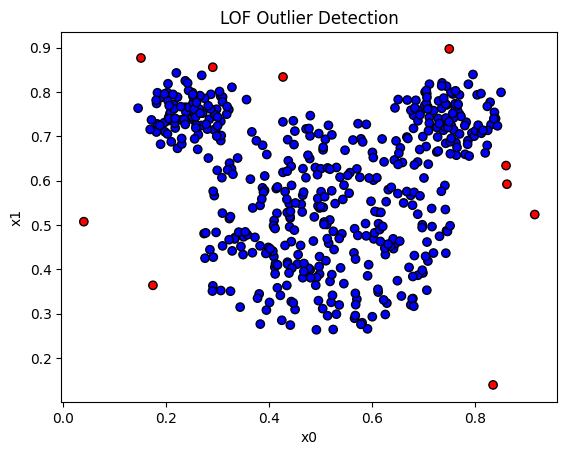

In [6]:
outliers = scores_lof < -1.5

colors = ['blue' if label == 0 else 'red' for label in outliers]

# Plot the data points and highlight the outliers
plt.scatter(data[0], data[1], c=colors, edgecolor='k')
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('LOF Outlier Detection')
plt.show()

## Isolation Forest

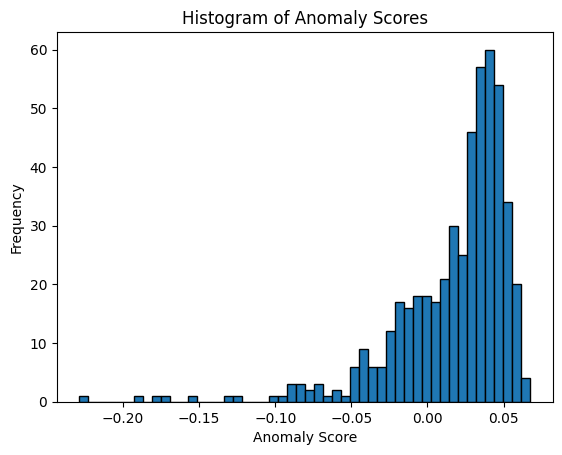

In [7]:
# Initialize the Isolation Forest model
iso_forest = IsolationForest(random_state=42)

# Fit the model and predict outliers
iso_forest.fit(data)

scores_IF = iso_forest.decision_function(data)

# Plot the histogram of anomaly scores
plt.hist(scores_IF, bins=50, edgecolor='k')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Histogram of Anomaly Scores')
plt.show()

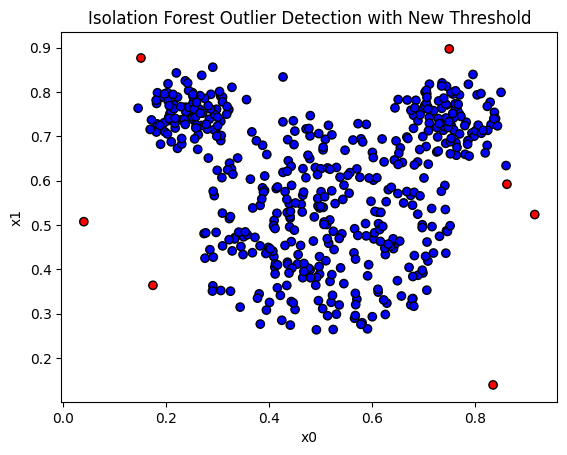

In [8]:
# Detect outliers based on the new threshold
new_outliers = scores_IF < -0.10

colors = ['blue' if label == 0 else 'red' for label in new_outliers]

# Plot the data points and highlight the new outliers
plt.scatter(data[0], data[1], c=colors, edgecolor='k')
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('Isolation Forest Outlier Detection with New Threshold')
plt.show()

On remarque que le LOF semble mieux détécter les anomalies que l'Isolation Forest, pour laquelle on observe quelques points qui semblent écartés du dataset mais qui ne sont pas détectés comme positifs.

# Jeu de données des fraudes bancaires

## 1. Préparation des données

On réalise une normalisation des données, car cela permet d'avoir de meilleurs résultats et des convergences plus rapides, notamment pour la régression logistique et lorsqu'on applique des algorithmes de 'plus proches voisins'.

In [3]:
def data_preprocessing_fraud(filepath : str) -> tuple:
    '''
    Cette fonction prend en entrée le chemin du fichier de données et retourne les données prétraitées, sous la forme d'un tuple (X, y).
    '''
    data = pd.read_csv(filepath)
    data_clean = data.drop('Time', axis=1)

    scaler = StandardScaler()

    data_normalized = data_clean.copy()
    data_normalized.iloc[:, :-1] = scaler.fit_transform(data_clean.iloc[:, :-1])
    
    y = data_normalized['Class']
    X = data_normalized.drop('Class', axis=1)

    return X, y

X, y = data_preprocessing_fraud('creditcard.csv')

On n'a pas réellement réaliser de grid serch dans ce notebook car cela était trop gourmand en resources, et l'entrainemet des modèles était trop long.

In [4]:
def grid_search_cv(X, y, model, param_grid):

    grid_search = GridSearchCV(model, param_grid, scoring='average_precision', cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), verbose=2, n_jobs=-1)
    
    grid_search.fit(X, y)

    return grid_search.best_score_


On n'a pas réalisé de cross-validation pour les même raisons de durée d'entraineent de nos modèles.

In [5]:
def cross_validation(X, y, model):

    scores = cross_val_score(model, X, y, scoring='average_precision', cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=-1) 

    return scores.mean()

On réalise donc une séparation stratifiée entre le jeu d'entrainement et le jeu de test. De cette manière on garde la même proportion de chaque classe de nos labels dans les deux jeux de données.

In [7]:
def train_test_split_vanilla(X,y,model):
    
    '''
    Cette fonction prend en entrée les données X et les étiquettes y, et retourne les données d'entraînement et de test.
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    f1 = f1_score(y_test, y_pred)

    recall, precision, _ = precision_recall_curve(y_test, y_pred)
    average_precision = average_precision_score(y_test, y_pred)

    report = classification_report(y_test, y_pred)
    print(report)

    plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % average_precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

    return f1

Dans cette séparation entre jeux de données d'entrainement et de test, on ajoute également des méthode d'over-sampling ou d'under-sampling sur les données d'entrainement.

In [6]:
def train_test_split_unbalanced(X, y, classifier_model, sampling_model):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    X_train_resampled, y_train_resampled = sampling_model.fit_resample(X_train, y_train)

    classifier_model.fit(X_train_resampled, y_train_resampled)

    y_pred = classifier_model.predict(X_test)

    f1 = f1_score(y_test, y_pred)

    recall, precision, _ = precision_recall_curve(y_test, y_pred)
    average_precision = average_precision_score(y_test, y_pred)

    report = classification_report(y_test, y_pred)
    print(report)

    plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % average_precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")


    return f1

Cette fonction nous permet de calculer les métriques F1 score et average precision score pour nos modèles 

In [8]:
def detection_mean_score(X, y, model,sampling_model = None, cross_val = False, grid_search = False, param_grid = None):

    if grid_search and param_grid is not None:
        score = grid_search_cv(X, y, model, param_grid)
    elif sampling_model is None:
        score = train_test_split_vanilla(X, y, model)
    else:
        score = train_test_split_unbalanced(X, y, model, sampling_model)
        

    return score

### Régression logistique

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.64      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962

F1 score for Logistic Regression: 0.7241379310344828


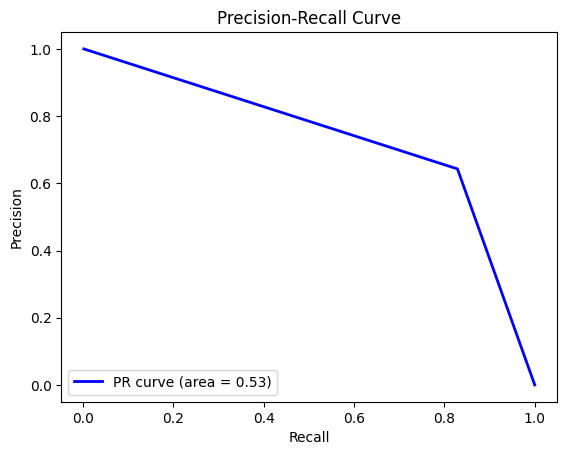

In [13]:
# Initialize the Logistic Regression model
log_reg = LogisticRegression()

# Perform cross-validation
log_reg_score = detection_mean_score(X, y, log_reg)

print("F1 score for Logistic Regression:", log_reg_score)

### SMOTE

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.98     56962

F1 score for Logistic Regression after over-sampling with SMOTE: 0.1053247513165594


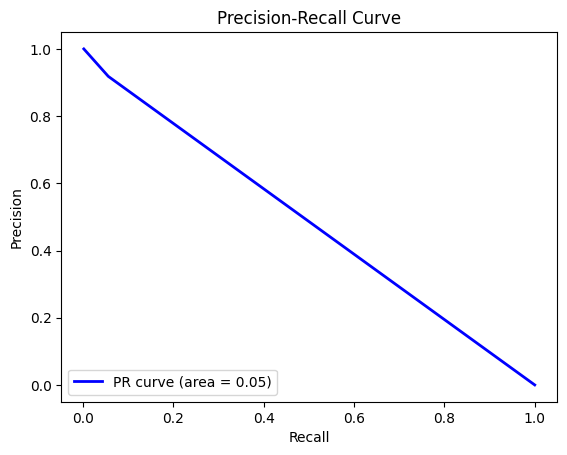

In [14]:
log_reg_smote = LogisticRegression()

smote = SMOTE(random_state=42)

log_reg_smote_score = detection_mean_score(X, y, log_reg_smote, sampling_model=smote)

print("F1 score for Logistic Regression after over-sampling with SMOTE:", log_reg_smote_score)

### Tomek links

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.64      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962



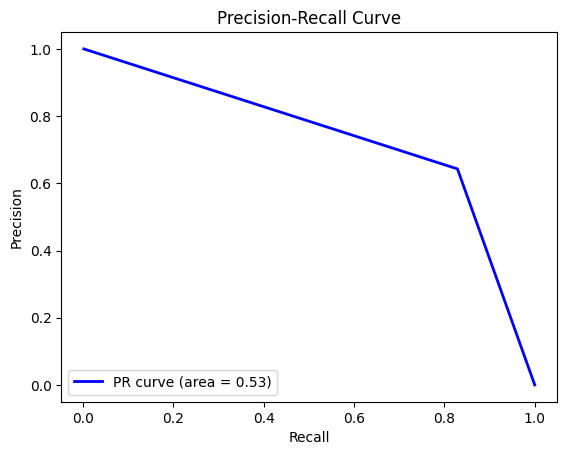

In [16]:
log_reg_tomek = LogisticRegression()

tomek = TomekLinks(sampling_strategy='majority')

log_reg_tomek_score = detection_mean_score(X, y, log_reg_tomek, sampling_model=tomek)

### Random Forest

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



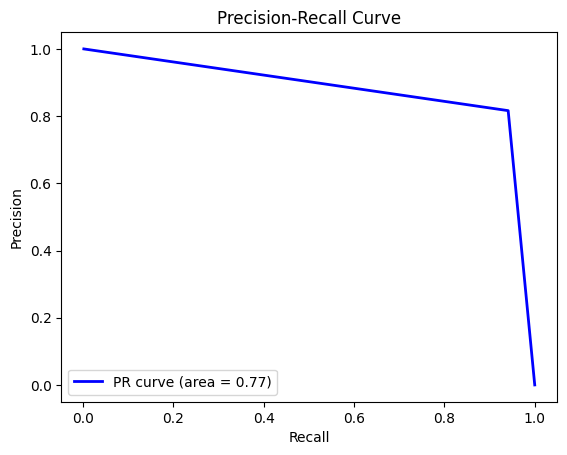

In [18]:
rf_model = RandomForestClassifier(random_state=42)

rf_score = detection_mean_score(X, y, rf_model)

### RF + SMOTE

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.87      0.85        98

    accuracy                           1.00     56962
   macro avg       0.92      0.93      0.92     56962
weighted avg       1.00      1.00      1.00     56962



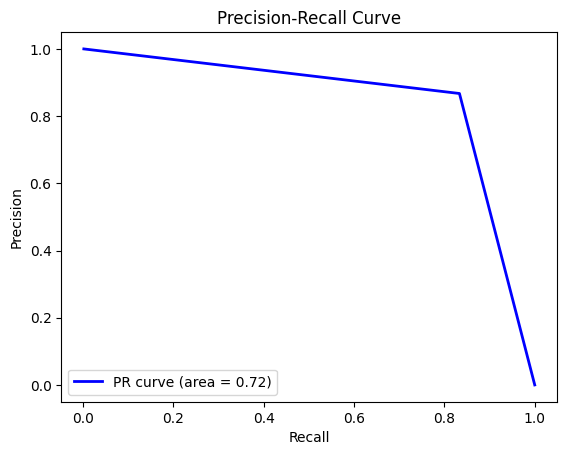

In [23]:
rf_smote = RandomForestClassifier(n_estimators=200)

smote = SMOTE(random_state=42, sampling_strategy=0.1, k_neighbors=20)

rf_smote_score = detection_mean_score(X, y, rf_smote, sampling_model=smote)

Nous avons complexifié le modèle de Random Forest car nous avons rajouté des données par le biais du SMOTE. Cependant, malgrès cette complexification, on remarque que les résultats ne sont pas meilleurs en utilisant la méthode d'oversampling SMOTE.

### RF + TomekLinks

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.96      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962



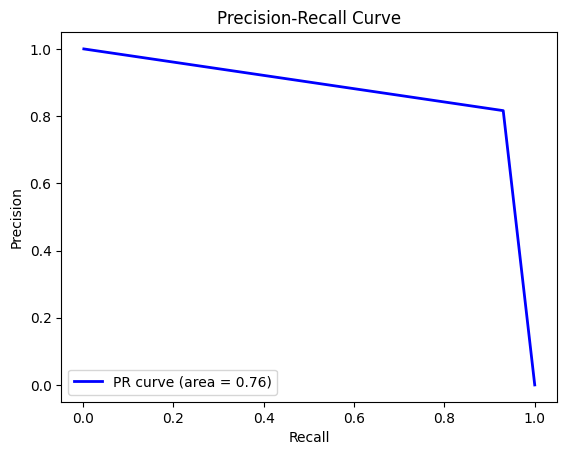

In [17]:
rf_tomek = RandomForestClassifier()

tomek = TomekLinks(sampling_strategy='majority')

rf_tomek_score = detection_mean_score(X, y, rf_tomek, sampling_model=tomek)

### Balanced Random Forest

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.89      0.18        98

    accuracy                           0.99     56962
   macro avg       0.55      0.94      0.59     56962
weighted avg       1.00      0.99      0.99     56962



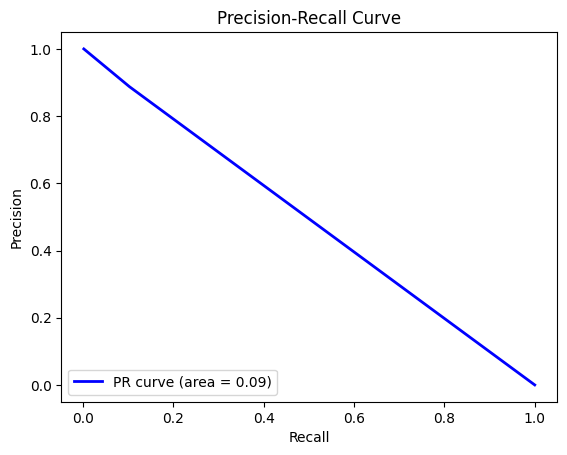

In [21]:
balanced_rf = BalancedRandomForestClassifier(random_state=42, class_weight='balanced')

balanced_rf_score = detection_mean_score(X, y, balanced_rf)

### LOF

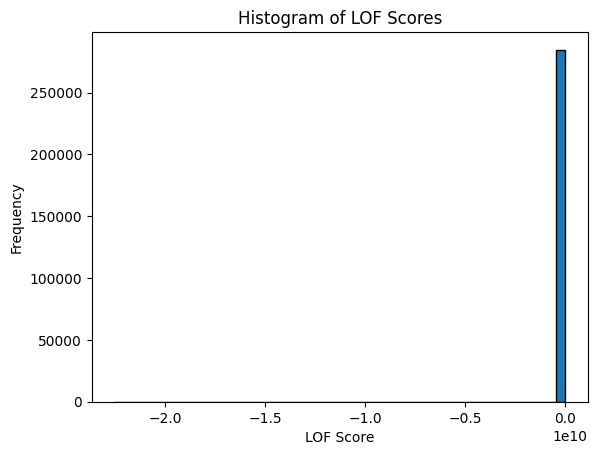

In [9]:
lof = LocalOutlierFactor(n_neighbors=20)

lof.fit(X)

# Get the LOF scores
scores_lof = lof.negative_outlier_factor_

# Plot the histogram of LOF scores
plt.hist(scores_lof, bins=50, edgecolor='k')
plt.xlabel('LOF Score')
plt.ylabel('Frequency')
plt.title('Histogram of LOF Scores')
plt.show()


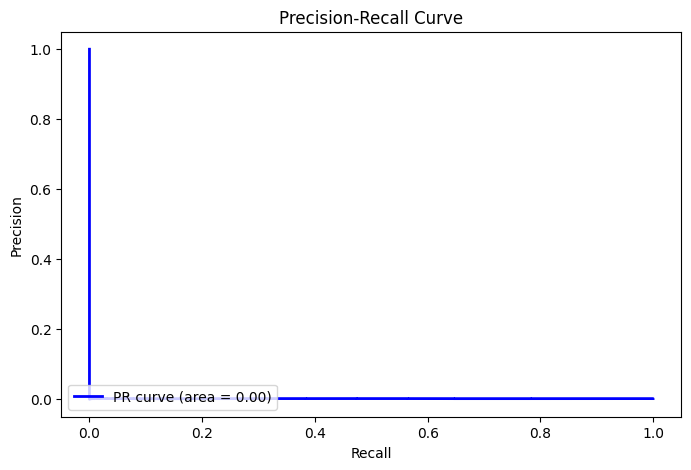

In [10]:
y_scores = lof.negative_outlier_factor_

# Calculate Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y, y_scores)
average_precision = average_precision_score(y, y_scores)

# Plot ROC curve
plt.figure(figsize=(8, 5))

plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")


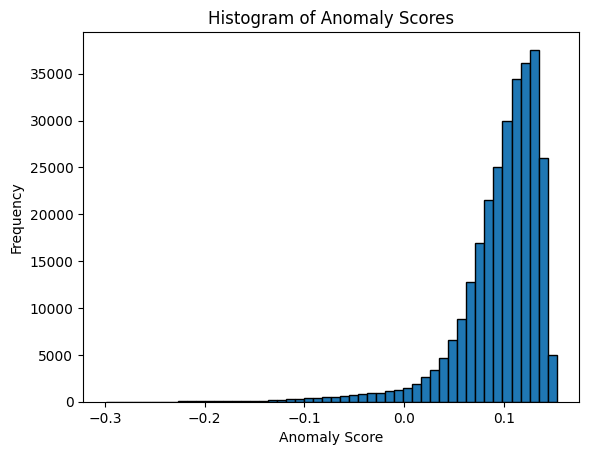

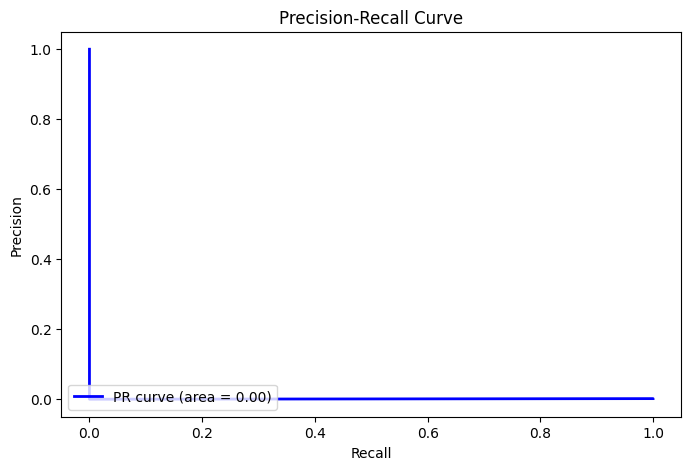

In [11]:
# Initialize the Isolation Forest model
iso_forest = IsolationForest(random_state=42)

# Fit the model and predict outliers
iso_forest.fit(X)

scores_IF = iso_forest.decision_function(X)

# Plot the histogram of anomaly scores
plt.hist(scores_IF, bins=50, edgecolor='k')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Histogram of Anomaly Scores')
plt.show()

# Calculate Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y, scores_IF)
average_precision = average_precision_score(y, scores_IF)


plt.figure(figsize=(8, 5))

plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

Les approches LOF et IsolationForest ne semblent pas adaptés à notre problème. En effet, en traçant les histogramme des scores pour les deux méthodes, aucun groupe d'inlier ou d'outlier ne se démarque. Il nous est alors impossible de fixer un seuil qui va nous permettre de séparer les anomalie des observations normales. Cela reste vrai même en changeant le nombre de barres sur l'histogramme ou en complexifiant les modèles.

## Jeu de données KDDCup99

On va appliquer notre méthode de détection d'outlier au dataset *KDDCup99.csv*.

Nous devons d'abord faire un preprocessing des données (normalisation, encodage...)

In [ ]:
data_cup = pd.read_csv('KDDCup99.csv')
data_cup.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal


In [ ]:
data_cup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494020 entries, 0 to 494019
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494020 non-null  int64  
 1   protocol_type                494020 non-null  object 
 2   service                      494020 non-null  object 
 3   flag                         494020 non-null  object 
 4   src_bytes                    494020 non-null  int64  
 5   dst_bytes                    494020 non-null  int64  
 6   land                         494020 non-null  int64  
 7   wrong_fragment               494020 non-null  int64  
 8   urgent                       494020 non-null  int64  
 9   hot                          494020 non-null  int64  
 10  num_failed_logins            494020 non-null  int64  
 11  logged_in                    494020 non-null  int64  
 12  lnum_compromised             494020 non-null  int64  
 13 

Nous pouvons voir que nous avons 4 colonnes avec des données catégorielles, y compris la colonne d'étiquette.
Nous devons encoder ces colonnes afin de pouvoir utiliser nos modèles avec les données.

In [ ]:
category_columns = data_cup.select_dtypes(include='object').columns
category_columns

Index(['protocol_type', 'service', 'flag', 'label'], dtype='object')

In [ ]:
unique_labels = data_cup['label'].unique()
print(unique_labels)

['normal' 'buffer_overflow' 'loadmodule' 'perl' 'neptune' 'smurf'
 'guess_passwd' 'pod' 'teardrop' 'portsweep' 'ipsweep' 'land' 'ftp_write'
 'back' 'imap' 'satan' 'phf' 'nmap' 'multihop' 'warezmaster' 'warezclient'
 'spy' 'rootkit']


In [ ]:
# Get the counts of each unique value in the 'label' column
label_counts = data_cup['label'].value_counts()

label_counts/data_cup.shape[0]*100

label
smurf              56.837780
neptune            21.699729
normal             19.690903
back                0.445933
satan               0.321647
ipsweep             0.252419
portsweep           0.210518
warezclient         0.206469
teardrop            0.198170
pod                 0.053439
nmap                0.046759
guess_passwd        0.010728
buffer_overflow     0.006073
land                0.004251
warezmaster         0.004048
imap                0.002429
rootkit             0.002024
loadmodule          0.001822
ftp_write           0.001619
multihop            0.001417
phf                 0.000810
perl                0.000607
spy                 0.000405
Name: count, dtype: float64

On observe qu'il y a différents labels avec des occurences variées. On cherche ici à faire de la détection d'anomalies, on décide donc de considérer que tous les évènements qui arrivent peut fréquemment (inférieur à 1% du temps) sont des anomalies. On nomme alors les évènement normaux les bales 'smurf', 'neptune' et 'normal', et le reste seront des anomalies. Ainsi, on attribue aux évènement normaux la valeur 0 et aux autres la valeur 1.
Ainsi, par la suite, le but est d'entrainer des modèles qui sont capables de détecter ces évènements peu fréquents.

Concernant les variables prédictives, on ne peut cependant pas vraiment réaliser un encodage avec un 'Label Encoder', car on ajouterait un 'ordre' artificiel (0, 1, 2, 3), qui n'aurait pas de sens, ce qui pourrait biaiser nos modèles lors de l'entrainement.

Il n'est également pas vraiment adapté de réaliser un encodage 'One Hot', c'est-à-dire de créer une variable indicatrice par catégorie de chaque variable catégorielle, car il y a un grand nombre de catégories, et cela rendrait le jeu de données très lourd pour l'entrainement par la suite.

Nous avons donc décidé d'opter pour un encodage avec un 'Target Encoder', qui réalise un encodage similaire au 'Label Encoder' mais qui attribue comme valeur de chaque catégorie, la moyenne de leurs labels. De cette manière, si une catégorie a une valeur supérieure à une autre, cela a un sens par rapport au jeu de données, et n'est pas totalement artificiel.

On finit par normaliser ces variables également.

In [ ]:
# Replace 'smurf', 'neptune', and 'normal' with 0, and all other values with 1
data_cup['label'] = data_cup['label'].replace({'smurf': 0, 'neptune': 0, 'normal': 0}).apply(lambda x: 1 if x not in [0] else x)

In [ ]:
def data_preprocessing_datacup(filepath : str) -> tuple:
    '''
    Cette fonction prend en entrée le chemin du fichier de données et retourne les données prétraitées, sous la forme d'un tuple (X, y).
    '''
    data = pd.read_csv(filepath)

    scaler = StandardScaler()

    data['label'] = data['label'].replace({'smurf': 0, 'neptune': 0, 'normal': 0}).apply(lambda x: 1 if x not in [0] else x)

    enc_auto = TargetEncoder(smooth=100)
    scaler = StandardScaler()

    data['protocol_type'] = enc_auto.fit_transform(data['protocol_type'].to_numpy().reshape(-1, 1), data['label'].to_numpy().reshape(-1, 1))
    data['protocol_type'] = scaler.fit_transform(data[['protocol_type']])


    data['service'] = enc_auto.fit_transform(data['service'].to_numpy().reshape(-1, 1), data['label'].to_numpy().reshape(-1, 1))
    data['service'] = scaler.fit_transform(data[['service']])

    data['flag'] = enc_auto.fit_transform(data['flag'].to_numpy().reshape(-1, 1), data['label'].to_numpy().reshape(-1, 1))
    data['flag'] = scaler.fit_transform(data[['flag']])
    
    y = data['label']
    X = data.drop('label', axis=1)

    return X, y

X_cup, y_cup = data_preprocessing_datacup('KDDCup99.csv')

### Régression logistique

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     97054
           1       0.71      0.09      0.16      1750

    accuracy                           0.98     98804
   macro avg       0.85      0.55      0.58     98804
weighted avg       0.98      0.98      0.98     98804

F1 score for Logistic Regression: 0.1637190500252653


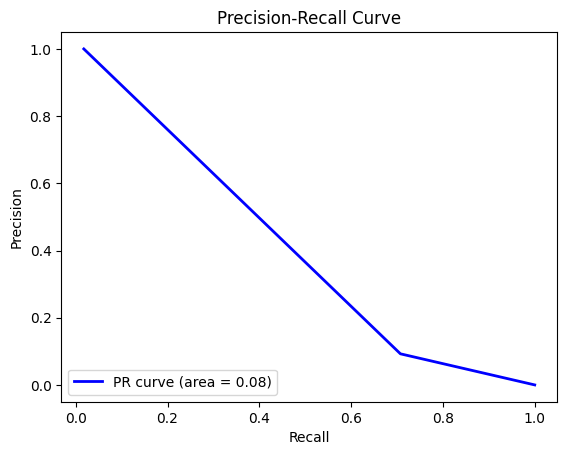

In [ ]:
# Initialize the Logistic Regression model
log_reg = LogisticRegression()

# Perform cross-validation
log_reg_score = detection_mean_score(X_cup, y_cup, log_reg)

print("F1 score for Logistic Regression:", log_reg_score)

### Régression logistique + SMOTE

              precision    recall  f1-score   support

           0       0.99      0.73      0.84     97054
           1       0.05      0.70      0.08      1750

    accuracy                           0.73     98804
   macro avg       0.52      0.72      0.46     98804
weighted avg       0.98      0.73      0.83     98804

F1 score for Logistic Regression after over-sampling with SMOTE: 0.08498112684835682


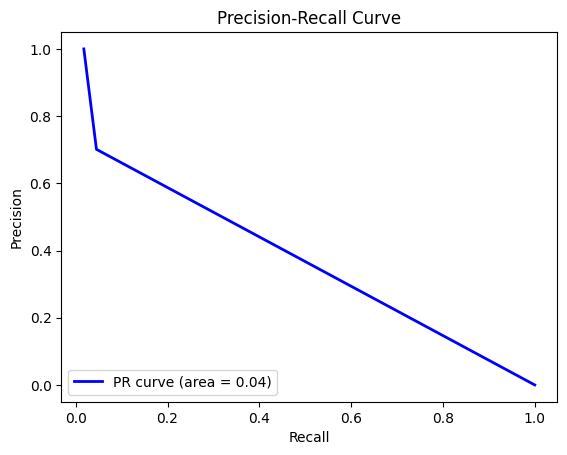

In [ ]:
log_reg_smote = LogisticRegression()

smote = SMOTE(random_state=42)

log_reg_smote_score = detection_mean_score(X_cup, y_cup, log_reg_smote, sampling_model=smote)

print("F1 score for Logistic Regression after over-sampling with SMOTE:", log_reg_smote_score)

### Régression logistique + Tomek links 

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     97054
           1       0.69      0.10      0.17      1750

    accuracy                           0.98     98804
   macro avg       0.84      0.55      0.58     98804
weighted avg       0.98      0.98      0.98     98804



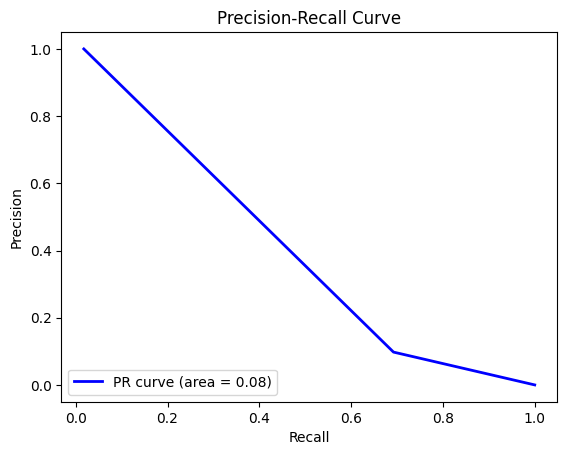

In [ ]:
log_reg_tomek = LogisticRegression()

tomek = TomekLinks(sampling_strategy='majority')

log_reg_tomek_score = detection_mean_score(X_cup, y_cup, log_reg_tomek, sampling_model=tomek)

### Random Forest

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     97054
           1       1.00      0.99      0.99      1750

    accuracy                           1.00     98804
   macro avg       1.00      0.99      1.00     98804
weighted avg       1.00      1.00      1.00     98804



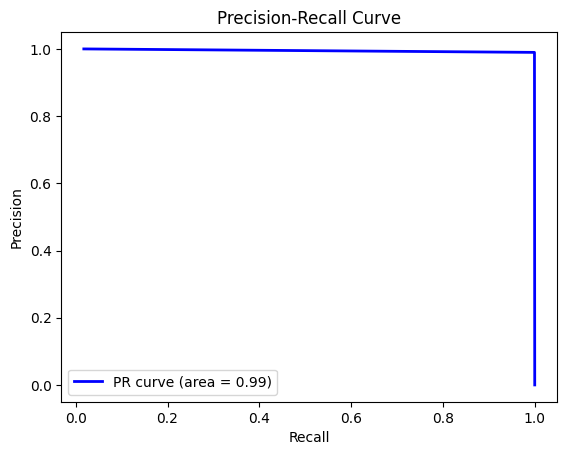

In [ ]:
rf_model = RandomForestClassifier(random_state=42)

rf_score = detection_mean_score(X_cup, y_cup, rf_model)

### RF + SMOTE

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     97054
           1       1.00      0.99      1.00      1750

    accuracy                           1.00     98804
   macro avg       1.00      1.00      1.00     98804
weighted avg       1.00      1.00      1.00     98804



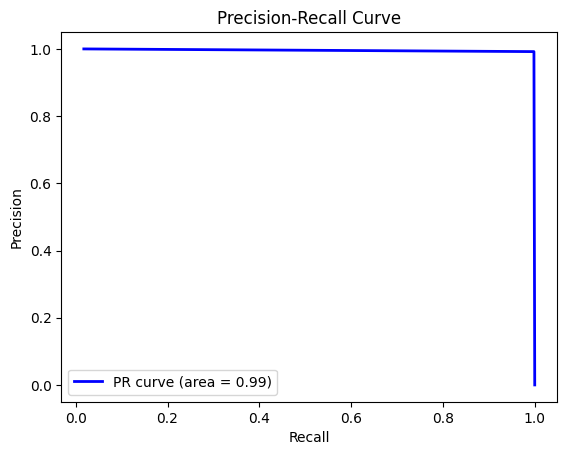

In [ ]:
rf_smote = RandomForestClassifier()

smote = SMOTE(random_state=42, sampling_strategy=0.1, k_neighbors=20)

rf_smote_score = detection_mean_score(X_cup, y_cup, rf_smote, sampling_model=smote)

### RF + TomekLinks

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     97054
           1       1.00      0.99      0.99      1750

    accuracy                           1.00     98804
   macro avg       1.00      0.99      1.00     98804
weighted avg       1.00      1.00      1.00     98804



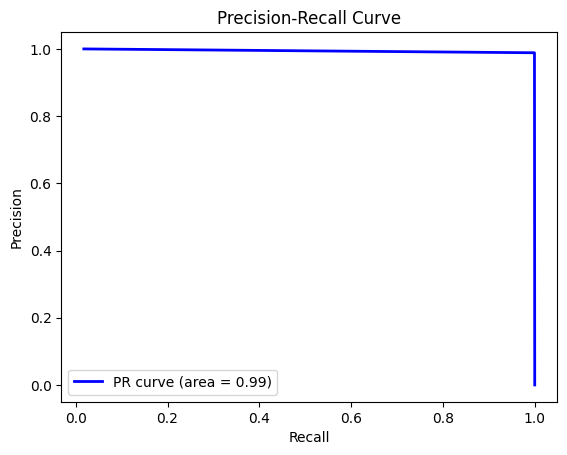

In [ ]:
rf_tomek = RandomForestClassifier()

tomek = TomekLinks(sampling_strategy='majority')

rf_tomek_score = detection_mean_score(X_cup, y_cup, rf_tomek, sampling_model=tomek)

### Balanced Random Forest

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     97054
           1       0.92      1.00      0.96      1750

    accuracy                           1.00     98804
   macro avg       0.96      1.00      0.98     98804
weighted avg       1.00      1.00      1.00     98804



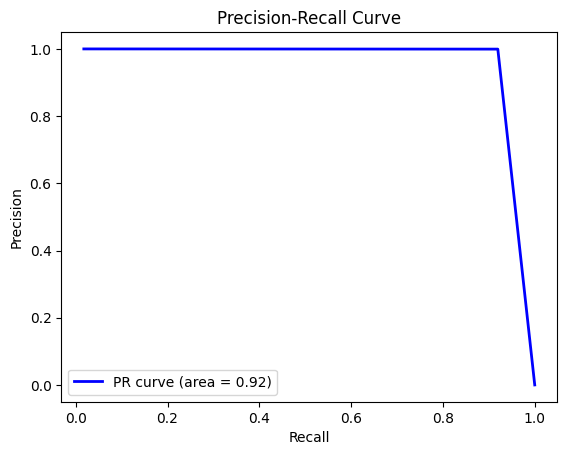

In [ ]:
balanced_rf = BalancedRandomForestClassifier(random_state=42, class_weight='balanced')

balanced_rf_score = detection_mean_score(X_cup, y_cup, balanced_rf)

Le meilleur modèle est donc RF + SMOTE d'après nos métriques choisies ici.